# SQUID

## initial imports

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import curve_fit
import scipy.constants as con
import uncertainties as un
import uncertainties.unumpy as unp
from scipy.signal import find_peaks
import scienceplots
plt.style.use('science')


In [3]:
# normalize
def normalize(arr, t_min, t_max):
    arr = arr.to_numpy()
    norm_arr = []
    diff = t_max - t_min
    diff_arr = max(arr) - min(arr)   
    for i in arr:
        temp = (((i - min(arr))*diff)/diff_arr) + t_min
        norm_arr.append(temp)
    return norm_arr
def simple_norm(arr):
    arr = arr.to_numpy()
    norm_arr = []
    diff = 1
    diff_arr = max(arr) - min(arr)   
    for i in arr:
        temp = (((i - min(arr))*diff)/diff_arr)
        norm_arr.append(temp)
    return norm_arr
def norm2(arr):
    arr = arr.to_numpy()
    diff_arr = max(arr) - min(arr)   
    return arr/diff_arr

def mapcolors(n):
    """Return a list of n colors from the default colormap"""
    return [plt.cm.jet(int(x*plt.cm.jet.N/n)) for x in range(n)]

## 1 Diode Calibration

### Load data

In [4]:
room_temp = pd.read_csv('SQUID/data/V-I/roomtemp.csv')
liquid_nitrogen = pd.read_csv('SQUID/data/V-I/crittemp.csv')
room_temp

,0_x,0_y
0,0.985322,33.925200
1,1.749933,102.407787
2,4.553510,172.417867
3,6.337605,239.627543
4,8.121699,307.855548
...,...,...
495,60.625049,1062.182331
496,61.134790,1062.182331
497,63.938367,1062.182331
498,65.467591,1062.182331


### analysis

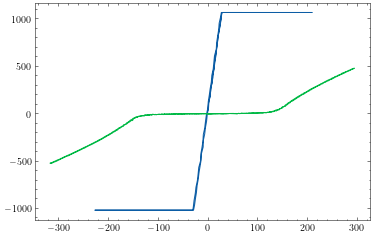

In [5]:
plt.plot(room_temp['0_x'], room_temp['0_y'], label='room temp')
plt.plot(liquid_nitrogen['0_x'], liquid_nitrogen['0_y'], label='liquid nitrogen')

/home/emil/.local/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


a = -373.1958762886597 b = 444.74793814432985


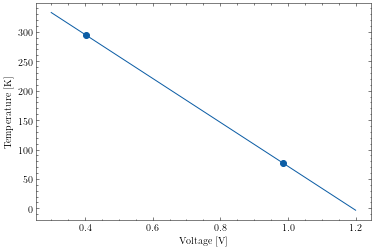

In [6]:
calibr_temp = [21.2+273.15, 77.15]
calibr_volts = [403*1e-3, 985*1e-3]

voltrange = np.linspace(300e-3, 1200e-3, 1000)

plt.scatter(calibr_volts, calibr_temp, label='calibration points')

# fit
def fit_func(x, a, b):
    return a*x + b

c , cov = curve_fit(fit_func, calibr_volts, calibr_temp)
plt.plot(voltrange, fit_func(voltrange, *c), label='fit')

plt.xlabel('Voltage [V]')
plt.ylabel('Temperature [K]')

print('a =', c[0], 'b =', c[1])

def temp(volt):
    return fit_func(volt, *c)

## 2 Temperature dependency

### Load data

Text(0, 0.5, 'Temperature [K]')

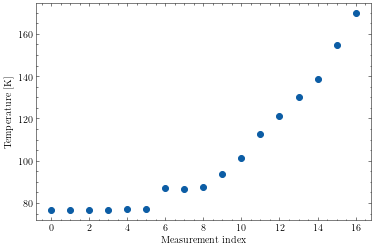

In [7]:
voltages = [986, 985.8, 986.6, 985.7, 985.2, 984.8, 958, 959.5, 957, 940, 920, 890, 867, 843, 820, 777, 736]
temps = temp(np.array(voltages)*1e-3)
plt.scatter(range(len(temps)), temps, label='measured temperatures')
plt.xlabel('Measurement index')
plt.ylabel('Temperature [K]')

### analysis

## 3 Flux dependency

### load data

In [8]:
flux1 = pd.read_csv('SQUID/data/V-Phi/11.01.2023 11.07.29_Trace.csv',skiprows=1)
flux2 = pd.read_csv('SQUID/data/V-Phi/11.01.2023 11.08.24_Trace.csv',skiprows=1)
flux3 = pd.read_csv('SQUID/data/V-Phi/11.01.2023 11.09.44_Trace.csv',skiprows=1)
flux4 = pd.read_csv('SQUID/data/V-Phi/11.01.2023 11.09.47_Trace.csv',skiprows=1)
flux5 = pd.read_csv('SQUID/data/V-Phi/11.01.2023 11.09.50_Trace.csv',skiprows=1)
knee = pd.read_csv('SQUID/data/V-I/knee.csv')
increment= 0.0000002 * 1e6 # step size in us 
flux4, knee

(      Sequence   VOLT   VOLT.1  0.01652000  0.0000002000000
 0            0   15.2   0.0448         NaN              NaN
 1            1   15.2   0.0464         NaN              NaN
 2            2   14.8   0.0456         NaN              NaN
 3            3   15.2   0.0488         NaN              NaN
 4            4   14.8   0.0488         NaN              NaN
 ...        ...    ...      ...         ...              ...
 1195      1195   15.2   0.0144         NaN              NaN
 1196      1196   14.8   0.0128         NaN              NaN
 1197      1197   15.2   0.0080         NaN              NaN
 1198      1198   15.2   0.0064         NaN              NaN
 1199      1199   14.8   0.0040         NaN              NaN
 
 [1200 rows x 5 columns],
             0_x        0_y         1_x        1_y         2_x        2_y  \
 0    120.009906   9.230736  120.519647  13.049468  120.264776  11.012811   
 1    121.029388   6.939497  119.755035   3.884512  120.009906   1.847855   
 2    120

### analysis

In [9]:
def sinfit(x, Delta_U, U_0, phi_s, phi_0):
    return Delta_U*np.sin(2*np.pi*(x-phi_s)/phi_0) + U_0
x = np.linspace(0, 6, 1000)

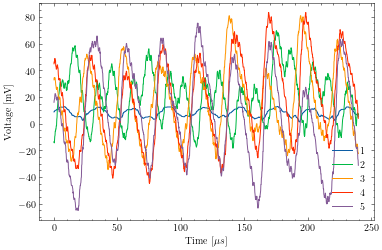

In [10]:
plt.plot(flux1['Sequence']*increment, flux1[' VOLT.1']*1e3, label='1')
plt.plot(flux2['Sequence']*increment, flux2[' VOLT.1']*1e3, label='2')
plt.plot(flux3['Sequence']*increment, flux3[' VOLT.1']*1e3, label='3')
plt.plot(flux4['Sequence']*increment, flux4[' VOLT.1']*1e3, label='4')
plt.plot(flux5['Sequence']*increment, flux5[' VOLT.1']*1e3, label='5')

plt.xlabel('Time [$\mu s$]')
plt.ylabel('Voltage [mV]')

plt.legend()

[38.98569971  5.6712316   1.1731034   1.41592513] [0.44661492 0.32376526 0.0039604  0.00227612]
\Delta U = 78.0+/-0.9 mV
U_0 = 5.67+/-0.32 mV
\phi_s = 11.73+/-0.04 us
\phi_0 = 14.159+/-0.023 us


Text(0, 0.5, 'Voltage [mV]')

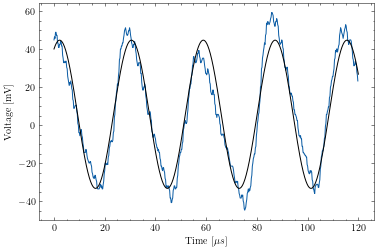

In [11]:
cut = 600
# plt.plot(flux1['Sequence'], flux1[' VOLT.1'], label='1')
# plt.plot(flux2['Sequence'], flux2[' VOLT.1'], label='2')
# plt.plot(flux3['Sequence']*1e-3, flux3[' VOLT.1']*1e3, label='3')
plt.plot(flux4['Sequence'][:cut]*increment, flux4[' VOLT.1'][:cut]*1e3, label='4')
# plt.plot(flux5['Sequence']*1e-3, flux5[' VOLT.1']*1e3, label='5')

c, cov = curve_fit(sinfit, flux4['Sequence'][:cut]*1e-2, flux4[' VOLT.1'][:cut]*1e3)
perr=np.sqrt(np.diag(cov))
plt.plot(x*increment/1e-2, sinfit(x, *c), label='fit',c='k')
print(c, perr)
print(f"\Delta U = {2*un.ufloat(c[0],perr[0])} mV")
print(f"U_0 = {un.ufloat(c[1],perr[1])} mV")
print(f"\phi_s = {un.ufloat(c[2],perr[2])*increment/2e-2} us")
print(f"\phi_0 = {un.ufloat(c[3],perr[3])*increment/2e-2} us")

plt.xlabel('Time [$\mu s$]')
plt.ylabel('Voltage [mV]')


Text(0, 0.5, 'Voltage in mV')

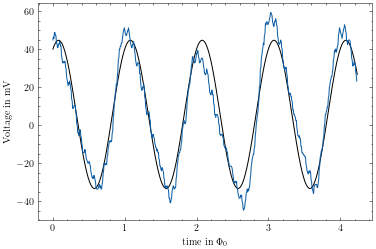

In [12]:
plt.plot(x/c[3], sinfit(x, *c), label='fit',c='k')
plt.plot(flux4['Sequence'][:cut]*1e-2/c[3], flux4[' VOLT.1'][:cut]*1e3, label='4')

plt.xlabel('time in $\Phi_0$')
plt.ylabel('Voltage in mV')

/home/emil/.local/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


(0.0, 50.0)

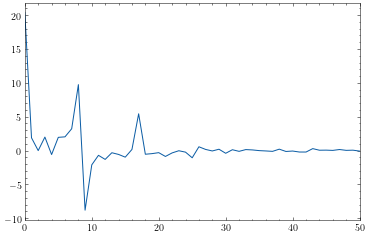

In [13]:
#fourier transform of the signal from flux4
plt.plot(np.fft.fft(flux4[' VOLT.1']))
plt.xlim(0,50)

# find peaks 

(0.0, 50.0)

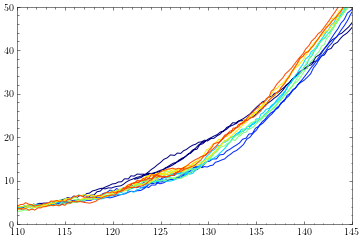

In [14]:
w= 15
plt.plot(knee['0_x'].rolling(window=w).mean(), knee['0_y'].rolling(window=w).mean(), label='1',c=mapcolors(6)[0])
plt.plot(knee['1_x'].rolling(window=w).mean(), knee['1_y'].rolling(window=w).mean(), label='2',c=mapcolors(6)[1])
plt.plot(knee['2_x'].rolling(window=w).mean(), knee['2_y'].rolling(window=w).mean(), label='3',c=mapcolors(6)[2])
plt.plot(knee['3_x'].rolling(window=w).mean(), knee['3_y'].rolling(window=w).mean(), label='4',c=mapcolors(6)[3])
plt.plot(knee['4_x'].rolling(window=w).mean(), knee['4_y'].rolling(window=w).mean(), label='5',c=mapcolors(6)[4])
plt.plot(knee['5_x'].rolling(window=w).mean(), knee['5_y'].rolling(window=w).mean(), label='6',c=mapcolors(6)[5])
plt.xlim(110,145)
plt.ylim(0,50)

## Flux quantum

### load data

In [16]:
steps=pd.read_csv('SQUID/data/mw-ind-steps.csv')
steps

,0_x,0_y,1_x,1_y,2_x,2_y,3_x,3_y,4_x,4_y
0,122.303741,152.560462,121.539129,182.091987,120.009906,217.733482,121.539129,100.625713,121.794000,9.994482
1,124.087836,157.906687,124.852448,188.201957,123.578094,223.588870,123.832965,109.026922,124.852448,4.648258
2,127.146283,160.961672,127.146283,188.201957,125.362189,228.171348,126.891413,111.572743,127.401154,13.813214
3,129.440119,164.271239,130.204731,195.584839,127.910895,233.772155,129.440119,119.210206,129.185248,10.758229
4,131.988825,167.835389,132.243696,198.385242,131.479084,238.100050,131.988825,124.301849,132.753437,19.668602
...,...,...,...,...,...,...,...,...,...,...
495,204.626955,271.195724,205.136696,302.509324,203.607472,335.604998,205.136696,258.212037,204.372084,237.081722
496,207.430532,270.941142,206.411049,308.619294,206.156178,335.859580,207.175661,260.757858,207.685402,245.482932
497,209.214626,276.287367,209.724367,312.692608,207.940273,340.951222,209.724367,265.594918,209.214626,252.865813
498,212.782815,276.796531,212.273074,318.038832,211.253591,342.733297,213.037685,270.177396,212.527944,258.721201


### analysis

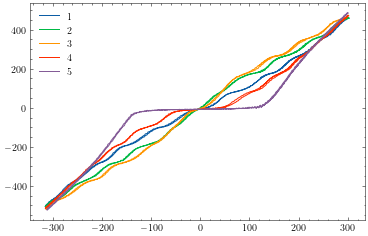

In [22]:
plt.plot(steps['0_x'], steps['0_y'], label='1')
plt.plot(steps['1_x'], steps['1_y'], label='2')
plt.plot(steps['2_x'], steps['2_y'], label='3')
plt.plot(steps['3_x'], steps['3_y'], label='4')
plt.plot(steps['4_x'], steps['4_y'], label='5')

plt.legend()
